<a href="https://colab.research.google.com/github/ahmadchoms/2025_Computer_Vision_TI_2A/blob/main/klasifikasi_gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

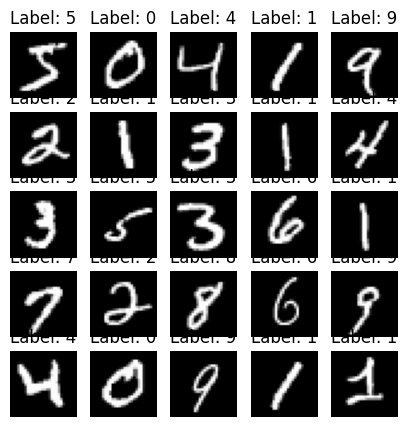

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from PIL import Image, ImageOps
from google.colab import files

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Tampilkan contoh
plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()

In [11]:
# Flatten
x_train_flat = x_train.reshape(len(x_train), -1) / 255.0
x_test_flat = x_test.reshape(len(x_test), -1) / 255.0

# SVM
clf = svm.SVC(kernel='rbf', gamma='scale')
clf.fit(x_train_flat[:5000], y_train[:5000]) # gunakan subset karena SVM berat
y_pred = clf.predict(x_test_flat)

print("Akurasi : ", accuracy_score(y_test, y_pred))

Akurasi :  0.9513


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9122 - loss: 0.2825 - val_accuracy: 0.9852 - val_loss: 0.0517
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9866 - loss: 0.0419 - val_accuracy: 0.9878 - val_loss: 0.0425
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9917 - loss: 0.0247 - val_accuracy: 0.9885 - val_loss: 0.0391
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9946 - loss: 0.0172 - val_accuracy: 0.9892 - val_loss: 0.0391
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9872 - val_loss: 0.0468


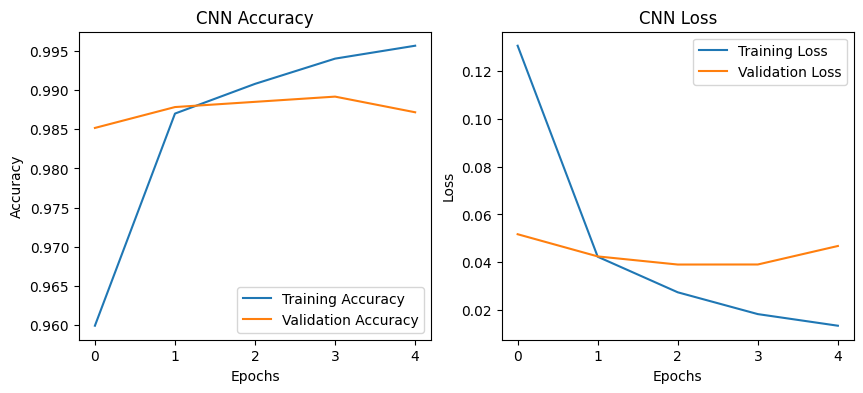

In [12]:
x_train_cnn = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test_cnn = x_test.reshape(-1, 28, 28, 1) / 255.0

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_cnn, y_train, epochs=5, validation_split=0.1)

# ===== Plot History =====
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Saving delapan.jpeg to delapan (2).jpeg


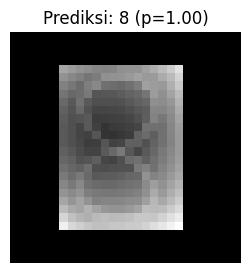

Rekap Prediksi (CNN):
- delapan (2).jpeg ==> 8 (p=1.000)


In [13]:
uploaded = files.upload()

def preprocess_to_mnist_28x28(img_pil):
  img = img_pil.convert('L')
  img = ImageOps.autocontrast(img)

  arr = np.array(img).astype(np.uint8)

  if arr.mean() > 127:
    img = ImageOps.invert(img)
    arr = np.array(img)

  thr = np.mean(arr) * .8
  mask = arr > thr
  if mask.any():
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    img = img.crop((x0, y0, x1+1, y1+1))

  img.thumbnail((20, 20), Image.Resampling.LANCZOS)
  w, h = img.size

  canvas = Image.new('L', (28, 28), color=0)
  canvas.paste(img, ((28 - w) // 2, (28 - h) // 2))

  arr = np.array(canvas).astype('float32') / 255.0

  arr = np.expand_dims(arr, axis=-1)
  return arr, canvas

results = []
for fname in uploaded.keys():
  img_pil = Image.open(fname)
  disp, x = preprocess_to_mnist_28x28(img_pil)
  x_batch = np.expand_dims(x, axis=0)
  probs = model.predict(x_batch, verbose=0)[0]
  pred = int(np.argmax(probs))
  conf = float(np.max(probs))

  results.append((fname, pred, conf))

  plt.figure(figsize=(3,3))
  plt.imshow(disp, cmap='gray')
  plt.title(f'Prediksi: {pred} (p={conf:.2f})')
  plt.axis('off')
  plt.show()

print("Rekap Prediksi (CNN):")
for r in results:
  print(f"- {r[0]} ==> {r[1]} (p={r[2]:.3f})")

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2494 - loss: 1.9856 - val_accuracy: 0.4698 - val_loss: 1.4774
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4235 - loss: 1.5747 - val_accuracy: 0.5666 - val_loss: 1.2247
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4921 - loss: 1.4076 - val_accuracy: 0.6036 - val_loss: 1.1528
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5179 - loss: 1.3273 - val_accuracy: 0.6214 - val_loss: 1.1147
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5507 - loss: 1.2569 - val_accuracy: 0.6376 - val_loss: 1.0410
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5636 - loss: 1.2045 - val_accuracy: 0.6612 - val_loss: 0.9796
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5856 - loss: 1.1624 - val_accuracy: 0.6704 - val_loss: 0.9722
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5958 - loss: 1.1348

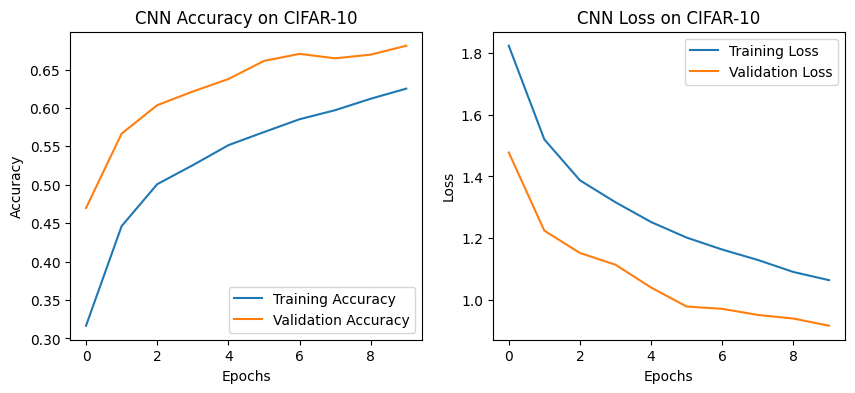

In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model =  models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_split=0.1)

# ===== Plot History =====
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy on CIFAR-10")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss on CIFAR-10")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3455 - loss: 1.8812 - val_accuracy: 0.5682 - val_loss: 1.2795
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5709 - loss: 1.2588 - val_accuracy: 0.6088 - val_loss: 1.1510
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6135 - loss: 1.1372 - val_accuracy: 0.6228 - val_loss: 1.0898
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6324 - loss: 1.0802 - val_accuracy: 0.6394 - val_loss: 1.0507
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6516 - loss: 1.0299 - val_accuracy: 0.6412 - val_loss: 1.0250


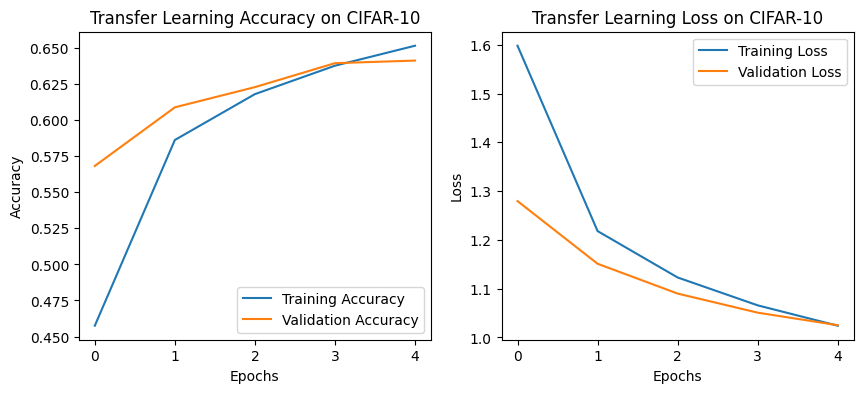

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False
for layer in base_model.layers[-2:]:
  layer.trainable = True

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, validation_split=0.1)

# ===== Plot History =====
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Transfer Learning Accuracy on CIFAR-10")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Transfer Learning Loss on CIFAR-10")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      1000
           1       0.73      0.69      0.71      1000
           2       0.63      0.44      0.52      1000
           3       0.45      0.54      0.49      1000
           4       0.54      0.62      0.58      1000
           5       0.59      0.52      0.55      1000
           6       0.69      0.66      0.68      1000
           7       0.71      0.68      0.69      1000
           8       0.79      0.70      0.74      1000
           9       0.66      0.72      0.69      1000

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.63     10000
weighted avg       0.64      0.63      0.63     10000



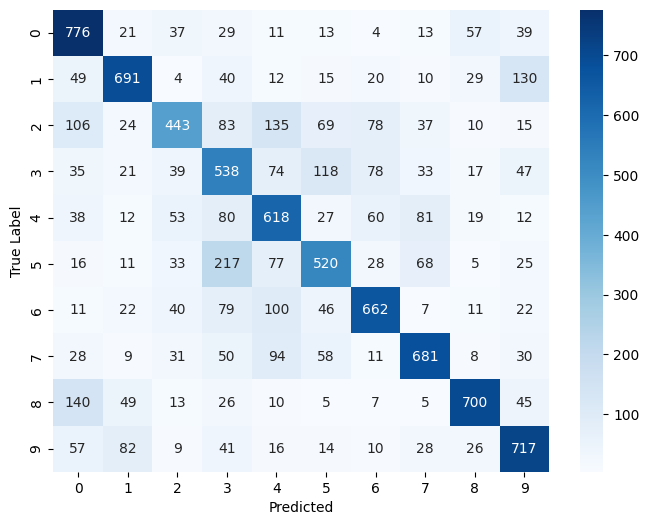

In [16]:
y_pred = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()